# Import thư viện

In [95]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Upload ảnh và chuyển thành grayscale

Kích thước ảnh: 187 x 270


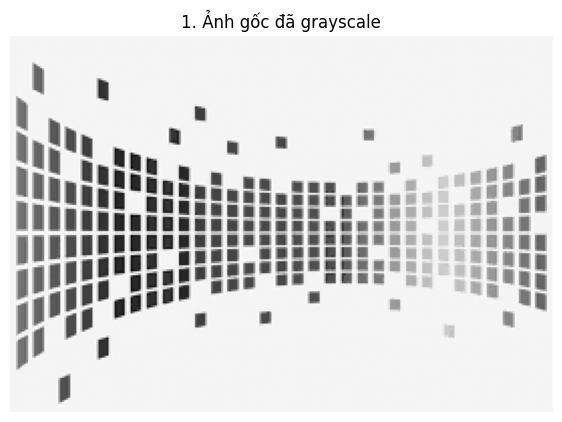

In [96]:
image_filename = "test.png"
original_img = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)

if original_img is None:
    raise ValueError("Không đọc được ảnh!")

height, width = original_img.shape
print(f"Kích thước ảnh: {height} x {width}")

# Hiển thị ảnh gốc ngay lập tức
plt.figure(figsize=(7, 7))
plt.imshow(original_img, cmap='gray')
plt.title("1. Ảnh gốc đã grayscale")
plt.axis('off')
plt.show()

# Tính peak, zero của histogram ban đầu

Peak: 246, Zero: 248


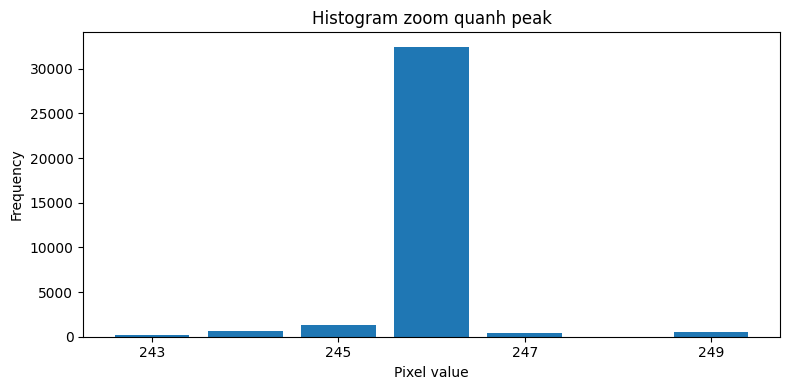

In [97]:
def compute_hist(img):
    hist = np.zeros(256, dtype=np.int64)
    h, w = img.shape
    for i in range(h):
        for j in range(w):
            hist[img[i, j]] += 1
    return hist

def find_optimal_zero(hist, peak):
    zero_left = None
    for i in range(peak - 1, -1, -1):
        if hist[i] == 0:
            zero_left = i
            break

    zero_right = None
    for i in range(peak + 1, 256):
        if hist[i] == 0:
            zero_right = i
            break

    if zero_left is None:
        return zero_right
    if zero_right is None:
        return zero_left

    if abs(peak - zero_left) <= abs(zero_right - peak):
        return zero_left
    else:
        return zero_right
hist = compute_hist(original_img) #tạo histogram của hình ảnh
peak = np.argmax(hist) #tìm giá trị pixel xuất hiện nhiều nhất
zero = find_optimal_zero(hist,peak) #Tìm giá trị pixel ít xuất hiện nhất, để tạo khoảng trống trong đoạn (zero,peak], để thực hiện dịch chuyển histogram lên 1 đơn vị, tạo khoảng trống
print(f"Peak: {peak}, Zero: {zero}")

peak = peak
zoom = 3
x = np.arange(peak - zoom, peak + zoom + 1)
hist_zoom = hist[x]
plt.figure(figsize=(8,4))
plt.bar(x, hist_zoom, width=0.8)
plt.title("Histogram zoom quanh peak")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.xticks(np.arange(peak - zoom, peak + zoom + 1, 2))
plt.tight_layout()
plt.show()





# Dịch chuyển Histogram

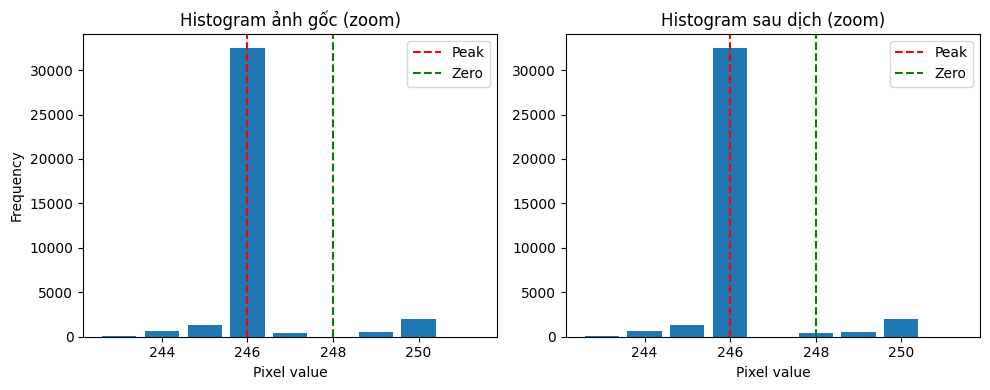

In [99]:
shifted = original_img.copy().astype(np.int32)

if zero > peak:
    for i in range(shifted.shape[0]):
        for j in range(shifted.shape[1]):
            if peak < shifted[i, j] < zero:
                shifted[i, j] += 1
else:
    for i in range(shifted.shape[0]):
        for j in range(shifted.shape[1]):
            if zero < shifted[i, j] < peak:
                shifted[i, j] -= 1
hist_original = compute_hist(original_img)
hist_shifted = compute_hist(shifted)

# ===== Tham số zoom =====
zoom_range = 3   # zoom ±6 quanh peak và zero

left = max(0, peak - zoom_range)
right = min(255, zero + zoom_range)

x = list(range(left, right + 1))
hist_o_zoom = hist_original[left:right + 1]
hist_s_zoom = hist_shifted[left:right + 1]

# ===== Vẽ histogram =====
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(x, hist_o_zoom)
plt.axvline(peak, color='r', linestyle='--', label='Peak')
plt.axvline(zero, color='g', linestyle='--', label='Zero')
plt.title("Histogram ảnh gốc (zoom)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1,2,2)
plt.bar(x, hist_s_zoom)
plt.axvline(peak, color='r', linestyle='--', label='Peak')
plt.axvline(zero, color='g', linestyle='--', label='Zero')
plt.title("Histogram sau dịch (zoom)")
plt.xlabel("Pixel value")
plt.legend()

plt.tight_layout()
plt.show()


# Nhúng dữ liệu vào Peak

In [100]:
secret_string = "Dang Truong dep tria dkjdkcdj"

# chuyển từng ký tự sang 8-bit binary
secret_bits = []

for char in secret_string:
    binary = format(ord(char), '08b')   # ví dụ 'H' -> 01001000
    secret_bits.extend([int(b) for b in binary])
num_bits = len(secret_bits)
available_capacity = np.sum(shifted == peak)

if num_bits > available_capacity:
    raise ValueError("Không đủ pixel peak để nhúng!")

embedded_img = shifted.copy()
bit_index = 0

h, w = embedded_img.shape
print(secret_bits)
# ====== Nhúng dữ liệu ======
for i in range(h):
    for j in range(w):
        if embedded_img[i, j] == peak:
            if bit_index < num_bits:
                if secret_bits[bit_index] == 1:
                    embedded_img[i, j] = peak + 1
                bit_index += 1
            else:
                break
    if bit_index >= num_bits:
        break

print("Số bit đã nhúng:", bit_index)

cv2.imwrite("stego.png", embedded_img.astype(np.uint8))
print("Đã lưu stego.png")



[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Số bit đã nhúng: 232
Đã lưu stego.png


Histogram sau khi nhúng dữ liệu


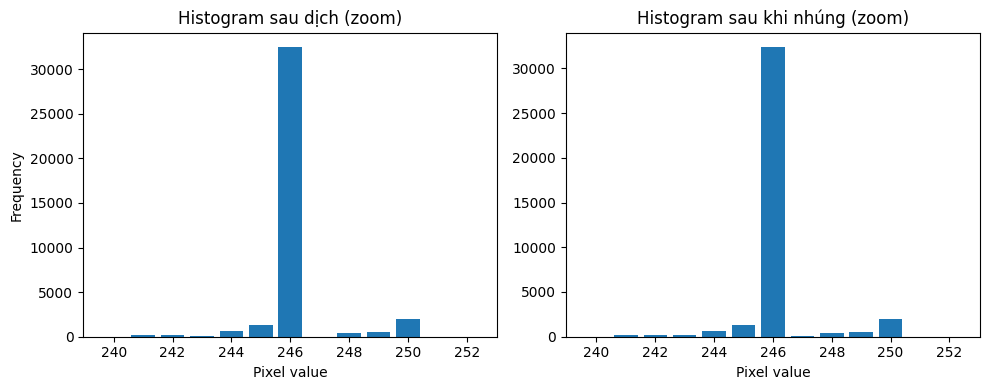

In [101]:
hist_embedded = compute_hist(embedded_img)
zoom = 6
x = np.arange(peak - zoom, peak + zoom + 1)

hist_shifted_zoom = hist_shifted[x]
hist_embedded_zoom = hist_embedded[x]

plt.figure(figsize=(10,4))

# Trước khi nhúng (sau khi dịch)
plt.subplot(1,2,1)
plt.bar(x, hist_shifted_zoom)
plt.title("Histogram sau dịch (zoom)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.xticks(np.arange(peak - zoom, peak + zoom + 1, 2))

# Sau khi nhúng
plt.subplot(1,2,2)
plt.bar(x, hist_embedded_zoom)
plt.title("Histogram sau khi nhúng (zoom)")
plt.xlabel("Pixel value")
plt.xticks(np.arange(peak - zoom, peak + zoom + 1, 2))

plt.tight_layout()
plt.show()


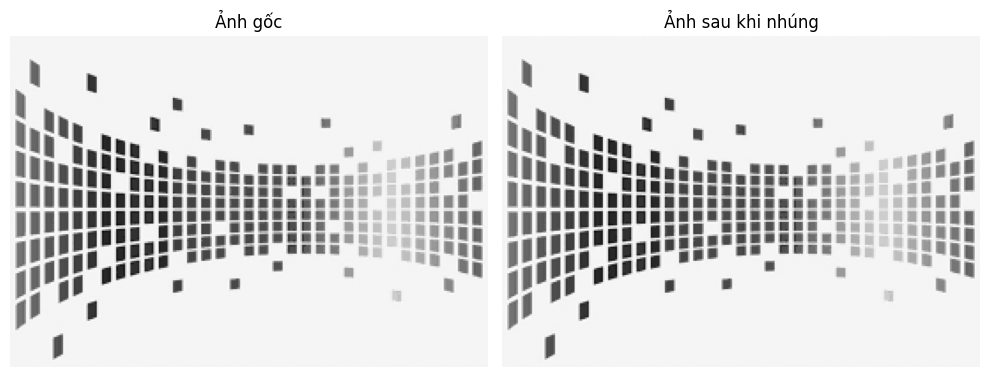

MSE: 0.011130917
PSNR: 67.6655 dB


In [102]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(original_img, cmap='gray')
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(embedded_img, cmap='gray')
plt.title("Ảnh sau khi nhúng")
plt.axis("off")

plt.tight_layout()
plt.show()

mse = np.mean((original_img.astype(np.float32) -
               embedded_img.astype(np.float32)) ** 2)

print("MSE:", mse)

if mse == 0:
    psnr = float('inf')
else:
    psnr = 10 * np.log10((255 ** 2) / mse)

print("PSNR:", psnr, "dB")



# Trích xuất dữ liệu và phục hồi ảnh gốc

In [103]:
stego_loaded = cv2.imread("stego.png", cv2.IMREAD_GRAYSCALE)
extracted_bits = []

h, w = stego_loaded.shape

for i in range(h):
    for j in range(w):
        if stego_loaded[i, j] == peak:
            extracted_bits.append(0)
        elif stego_loaded[i, j] == peak + 1:
            extracted_bits.append(1)

        if len(extracted_bits) >= num_bits:
            break
    if len(extracted_bits) >= num_bits:
        break

print("Số bit trích xuất:", len(extracted_bits))

binary_string = ''.join(str(b) for b in extracted_bits)

chars = []
for i in range(0, len(binary_string), 8):
    byte = binary_string[i:i+8]
    chars.append(chr(int(byte, 2)))

recovered_text = ''.join(chars)

print("Text khôi phục:", recovered_text)


Số bit trích xuất: 232
Text khôi phục: Dang Truong dep tria dkjdkcdj


Phục hồi ảnh

In [107]:
recovered_img = stego_loaded.copy()

h, w = recovered_img.shape

if zero > peak:
    for i in range(h):
        for j in range(w):

            if recovered_img[i, j] == peak + 1:
                recovered_img[i, j] = peak

            elif peak < recovered_img[i, j] <= zero:
                recovered_img[i, j] -= 1

else:
    for i in range(h):
        for j in range(w):

            if recovered_img[i, j] == peak - 1:
                recovered_img[i, j] = peak

            elif zero <= recovered_img[i, j] < peak:
                recovered_img[i, j] += 1


mse_recovered = np.mean(
    (original_img.astype(np.float32) -
     recovered_img.astype(np.float32)) ** 2
)

print("MSE sau phục hồi:", mse_recovered)
diff = np.abs(original_img.astype(int) - recovered_img.astype(int))


MSE sau phục hồi: 0.0


Số pixel khác nhau: 0
Sai lệch lớn nhất: 0
MSE: 0.0
PSNR: inf dB


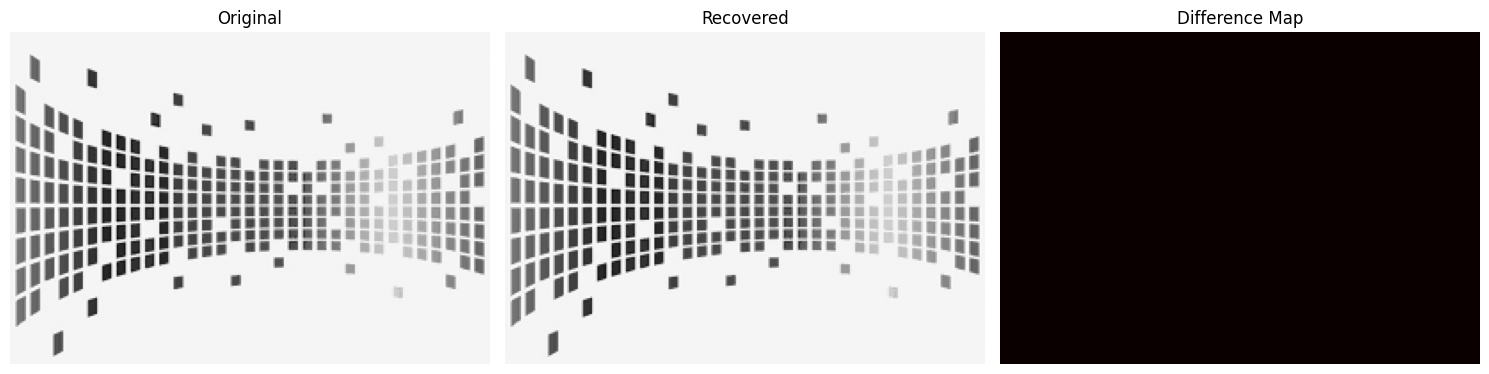

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Kiểm tra kích thước ====
if original_img.shape != recovered_img.shape:
    raise ValueError("Hai ảnh không cùng kích thước!")

# ==== Tính sai khác ====
diff = original_img.astype(np.int32) - recovered_img.astype(np.int32)
abs_diff = np.abs(diff)

num_diff = np.sum(abs_diff != 0)
max_diff = np.max(abs_diff)

print("Số pixel khác nhau:", num_diff)
print("Sai lệch lớn nhất:", max_diff)

# ==== Tính MSE ====
mse = np.mean((original_img.astype(np.float32) -
               recovered_img.astype(np.float32)) ** 2)

print("MSE:", mse)

# ==== Tính PSNR ====
if mse == 0:
    psnr = float('inf')
else:
    psnr = 10 * np.log10((255 ** 2) / mse)

print("PSNR:", psnr, "dB")

# ==== Hiển thị ảnh ====
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(recovered_img, cmap='gray')
plt.title("Recovered")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(abs_diff, cmap='hot')
plt.title("Difference Map")
plt.axis("off")

plt.tight_layout()
plt.show()
